# WeakAlign demo notebook

This notebook shows how to run a trained model on a given image pair

## Imports

In [66]:
from __future__ import print_function, division
import os
from os.path import exists
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric, TwoStageCNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_pascal
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict
import torch.nn.functional as F
import glob
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
from model.loss import TransformedGridLoss, WeakInlierCount, TwoStageWeakInlierCount

## Parameters

In [3]:
# Select one of the following models:
# cnngeo_vgg16, cnngeo_resnet101, proposed_resnet101
model_selection = 'proposed_resnet101' 

model_aff_path = ''
model_tps_path = ''
model_aff_tps_path = ''

if model_selection=='cnngeo_vgg16':
    model_aff_path = 'trained_models/trained_models/cnngeo_vgg16_affine.pth.tar'
    model_tps_path = 'trained_models/trained_models/cnngeo_vgg16_tps.pth.tar'
    feature_extraction_cnn = 'vgg'
    
elif model_selection=='cnngeo_resnet101':
    model_aff_path = 'trained_models/trained_models/cnngeo_resnet101_affine.pth.tar'
    model_tps_path = 'trained_models/trained_models/cnngeo_resnet101_tps.pth.tar'   
    feature_extraction_cnn = 'resnet101'
    
elif model_selection=='proposed_resnet101':
    model_aff_tps_path = 'trained_models/weakalign_resnet101_affine_tps.pth.tar'
    feature_extraction_cnn = 'resnet101'
    

source_image_path='datasets/proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2008_006325.jpg'
target_image_path='datasets/proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2010_004954.jpg'
source_image_path='datasets/3.JPEG'
target_image_path='datasets/4.JPEG'
if not exists(source_image_path):
    download_PF_pascal('datasets/proposal-flow-pascal/')

## Load models

In [4]:
use_cuda = torch.cuda.is_available()

model = TwoStageCNNGeometric(use_cuda=use_cuda,
                             return_correlation=True,
                             feature_extraction_cnn=feature_extraction_cnn)

# load pre-trained model
if model_aff_tps_path!='':
    checkpoint = torch.load(model_aff_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
        
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression.' + name])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression2.' + name])    
else:
    checkpoint_aff = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint_aff['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_aff['state_dict'].items()])
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureRegression.' + name])

    checkpoint_tps = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint_tps['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_tps['state_dict'].items()])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint_tps['state_dict']['FeatureRegression.' + name])

In [5]:
arg_groups = {'tps_grid_size': 3, 'tps_reg_factor': 0.2, 'normalize_inlier_count': True, 'dilation_filter': 0, 'use_conv_filter': False}

## inlier counter 모듈 인스턴스

In [6]:
inliersAffine = WeakInlierCount(geometric_model='affine',**arg_groups)
#inliersTps = WeakInlierCount(geometric_model='tps',**arg_groups['weak_loss'])
inliersComposed = TwoStageWeakInlierCount(use_cuda=use_cuda,**arg_groups)

# Pascal dataset 가져오기

In [7]:
from data.pf_dataset import PFDataset, PFPascalDataset
from data.download_datasets import download_PF_willow

In [8]:
pf_path='datasets/proposal-flow-pascal/'

In [9]:
# Dataset and dataloader
dataset = PFPascalDataset(csv_file=os.path.join(pf_path, 'test_pairs_pf_pascal.csv'),
                    dataset_path=pf_path,
                    transform=NormalizeImageDict(['source_image','target_image']))
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)
batchTensorToVars = BatchTensorToVars(use_cuda=use_cuda)

## get one batch(4 images)

In [10]:
batch = iter(dataloader)

In [11]:
x = batch.next()

In [12]:
print(type(x), x.keys())

<class 'dict'> dict_keys(['source_image', 'target_image', 'source_im_size', 'target_im_size', 'source_points', 'target_points', 'L_pck'])


In [13]:
batch_source_img = x['source_image']
batch_target_img = x['target_image']

<class 'torch.FloatTensor'>
['__add__', '__and__', '__array__', '__array_wrap__', '__bool__', '__class__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ilshift__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rpow__', '__rshift__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_advanced_index_add

## un-normalizing and reshaping

In [33]:
source_img_numpy = normalize_image(batch_source_img, forward=False)[1].transpose(1, 0).transpose(1, 2).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


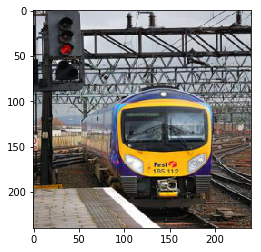

In [34]:
plt.imshow(source_img_numpy)

In [35]:
target_img_numpy = normalize_image(batch_target_img, forward=False)[1].transpose(1, 0).transpose(1, 2).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


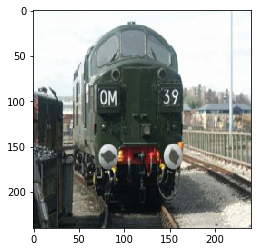

In [36]:
plt.imshow(target_img_numpy)

In [39]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)

In [45]:
type(x['source_image'])

torch.FloatTensor

## Batch FloatTensor To Variables

In [47]:
batch_tnf = BatchTensorToVars(use_cuda = True)

In [48]:
model.eval()

# Evaluate model
theta_aff,theta_aff_tps,corr_aff,corr_aff_tps=model(batch_tnf(x))

In [49]:
arg_groups = {'tps_grid_size': 3, 'tps_reg_factor': 0.2, 'normalize_inlier_count': True, 'dilation_filter': 0, 'use_conv_filter': False}

In [50]:
inliersAffine = WeakInlierCount(geometric_model='affine',**arg_groups)
#inliersTps = WeakInlierCount(geometric_model='tps',**arg_groups['weak_loss'])
inliersComposed = TwoStageWeakInlierCount(use_cuda=use_cuda,**arg_groups)

In [51]:
inliers_comp = inliersComposed(matches=corr_aff,
                                                 theta_aff=theta_aff,
                                                 theta_aff_tps=theta_aff_tps)

In [52]:
inliers_aff = inliersAffine(matches=corr_aff,
                                theta=theta_aff)

In [57]:
print(inliers_comp.cpu().data.numpy())

[0.08389137 0.0936434  0.08913884 0.09860846]


In [58]:
print(inliers_aff.cpu().data.numpy())

[0.08367512 0.08952495 0.08515125 0.09765913]


# Omniglot dataset 가져오기

In [77]:
n_epochs = 1
n_episodes = 10
n_way = 20
n_shot = 5
n_query = 5
n_examples = 20
im_width, im_height, channels = 128, 128, 1
h_dim = 64
z_dim = 64

In [78]:
# Load Train Dataset
data_generator_path = os.environ['DATA_GENERATOR']
train_split_path = os.path.join(data_generator_path, 'labels/omniglot', 'train.txt')
with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]
n_classes = len(train_classes)
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(train_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(data_generator_path, 'datasets/omniglot', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        train_dataset[i, j] = im
print(train_dataset.shape)

(4112, 20, 128, 128)


In [79]:
x = train_dataset[0]

## episodic input pipeline

In [75]:
for ep in range(n_epochs):
    for epi in range(n_episodes):
        epi_classes = np.random.permutation(n_classes)[:n_way]
        support = np.zeros([n_way, n_shot, im_height, im_width], dtype=np.float32)
        query = np.zeros([n_way, n_query, im_height, im_width], dtype=np.float32)
        for i, epi_cls in enumerate(epi_classes):
            selected = np.random.permutation(n_examples)[:n_shot + n_query]
            support[i] = train_dataset[epi_cls, selected[:n_shot]]
            query[i] = train_dataset[epi_cls, selected[n_shot:]]
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
        
        print('support', support.shape)
        print('query', query.shape)
#         _, ls, ac = sess.run([train_op, ce_loss, acc], feed_dict={x: support, q: query, y:labels})
#         if (epi+1) % 50 == 0:
#             print('[epoch {}/{}, episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(ep+1, n_epochs, epi+1, n_episodes, ls, ac))

support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)
support (20, 5, 28, 28, 1)
query (20, 5, 28, 28, 1)


## Create image transformers

In [ ]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)

## Load and preprocess images

In [ ]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [ ]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Evaluate model

In [ ]:
model.eval()

# Evaluate model
theta_aff,theta_aff_tps=model(batch)

## Compute warped images

In [ ]:
def affTpsTnf(source_image, theta_aff, theta_aff_tps, use_cuda=use_cuda):
    tpstnf = GeometricTnf(geometric_model = 'tps',use_cuda=use_cuda)
    sampling_grid = tpstnf(image_batch=source_image,
                           theta_batch=theta_aff_tps,
                           return_sampling_grid=True)[1]
    X = sampling_grid[:,:,:,0].unsqueeze(3)
    Y = sampling_grid[:,:,:,1].unsqueeze(3)
    Xp = X*theta_aff[:,0].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,1].unsqueeze(1).unsqueeze(2)+theta_aff[:,2].unsqueeze(1).unsqueeze(2)
    Yp = X*theta_aff[:,3].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,4].unsqueeze(1).unsqueeze(2)+theta_aff[:,5].unsqueeze(1).unsqueeze(2)
    sg = torch.cat((Xp,Yp),3)
    warped_image_batch = F.grid_sample(source_image, sg)

    return warped_image_batch

warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
warped_image_aff_tps = affTpsTnf(batch['source_image'],theta_aff,theta_aff_tps)

## Display

In [ ]:
# Un-normalize images and convert to numpy
warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

N_subplots = 4
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
axs[2].imshow(warped_image_aff_np)
axs[2].set_title('aff')
axs[3].imshow(warped_image_aff_tps_np)
axs[3].set_title('aff+tps')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()